# RNA Microarray Machine Learning

- Data source is from UCI Machine Learning Repo [https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq]
- The dataset is a collection gene expressions of patients having different types of tumor: BRCA(breast), KIRC(kidney), COAD(colon), LUAD(lung) and PRAD(prostate).


## Import Data and Exploration
The dataset contains 801 instances and 20531 features. It is a high dimensional low sample size dataset with multiple classes. The first step of the project is importing the dataset and perform some explorations of the dataset to gain some basic understanding. In terms of visualizations, it is difficult to visualize because of high dimensions. t -Distributed Stochastic Neighbor Embedding or t-SNE is a technique that I used to perform dimension reduction to visualize the data in 2D.




  Unnamed: 0  gene_0    gene_1    gene_2    gene_3     gene_4  gene_5  \
0   sample_0     0.0  2.017209  3.265527  5.478487  10.431999     0.0   
1   sample_1     0.0  0.592732  1.588421  7.586157   9.623011     0.0   
2   sample_2     0.0  3.511759  4.327199  6.881787   9.870730     0.0   
3   sample_3     0.0  3.663618  4.507649  6.659068  10.196184     0.0   
4   sample_4     0.0  2.655741  2.821547  6.539454   9.738265     0.0   

     gene_6    gene_7  gene_8     ...      gene_20521  gene_20522  gene_20523  \
0  7.175175  0.591871     0.0     ...        4.926711    8.210257    9.723516   
1  6.816049  0.000000     0.0     ...        4.593372    7.323865    9.740931   
2  6.972130  0.452595     0.0     ...        5.125213    8.127123   10.908640   
3  7.843375  0.434882     0.0     ...        6.076566    8.792959   10.141520   
4  6.566967  0.360982     0.0     ...        5.996032    8.891425   10.373790   

   gene_20524  gene_20525  gene_20526  gene_20527  gene_20528  gene_20529 

C:\Users\ziwei\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[t-SNE] Indexed 801 samples in 0.795s...
[t-SNE] Computed neighbors for 801 samples in 18.186s...
[t-SNE] Computed conditional probabilities for sample 801 / 801
[t-SNE] Mean sigma: 48.192174
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.251804
[t-SNE] Error after 300 iterations: 0.820377
TSNE took at 25.49 seconds


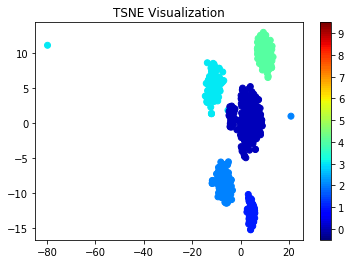

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import numpy as np
from numpy import genfromtxt
import time
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

data_path = "data/"
# load the dataset
X = pd.read_csv(data_path + "RNA_data/data.csv")
Y = pd.read_csv(data_path + "RNA_data/labels.csv")

# basic overview of data dimension
print(X.head())
print(X.dtypes)
print(Y.head())
print(Y.dtypes)

# convert dataframe into a numpy array
X = X.dropna()
# drop the first column which only contains strings
X = X.drop(X.columns[X.columns.str.contains('unnamed', case=False)], axis=1)
print("\n\nThe shape of dataset:")
print(X.shape)
print(Y.shape)

# label encode the multiple class string into integer values
Y = Y.drop(Y.columns[0], axis=1)
le = LabelEncoder()
le.fit(Y)
class_names = list(le.classes_)
print(class_names)

Y = Y.apply(LabelEncoder().fit_transform)
Y_data = Y.values.flatten()

# use TSNE to visualize the high dimension data in 2D
t0 = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=100)
tsne_results = tsne.fit_transform(X)
t1 = time.time()
print("TSNE took at %.2f seconds" % (t1 - t0))

# visualize TSNE
x_axis = tsne_results[:,0]
y_axis = tsne_results[:,1]
plt.scatter(x_axis, y_axis, c=Y_data, cmap=plt.cm.get_cmap("jet", 100))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.title("TSNE Visualization")
plt.show()

The TSNE algorithm is a dimension reduction algorithm that allows us to visualize high dimensional data in lower dimensions. We see that dataset form five clusters, which correlates with the five different tumor types.

## Split Dataset into Train and Test



In [3]:
# split data into training and testing set
X_train, X_test, Y_train, Y_test \
    = train_test_split(X, Y, test_size=0.20, random_state=100, stratify=Y, shuffle=True)

# save the train and test csv files
X_train.to_csv(data_path+"X_train.csv")
X_test.to_csv(data_path+"X_test.csv")
Y_train.to_csv(data_path+"Y_train.csv")
Y_test.to_csv(data_path+"Y_test.csv")

## Data Preprocessing

In order for the dataset to feed into machine learning algorithms, every feature and label intended for machine learning should be numerical and scaled appropriately. In the previous step, we have transformed the labels into numerical values in preparing for t-SNE. The RNA expression features are already expressed in float numbers. Scaling is not necessary here because all feature data came from microarray measures. The only operation we need to perform is transforming panda data frame into arrays.

In [4]:
# load the training data
X_train = pd.read_csv(data_path+"X_train.csv").values
Y_train = pd.read_csv(data_path+"Y_train.csv").values

X_test = pd.read_csv(data_path+"X_test.csv").values
Y_test = pd.read_csv(data_path+"Y_test.csv").values

# transform panda df into arrays
X_train = np.delete(X_train, 0, axis=1)
Y_train = np.delete(Y_train, 0, axis=1).flatten()

X_test = np.delete(X_test, 0, axis=1)
Y_test = np.delete(Y_test, 0, axis=1).flatten()

## Machine Learning Models

Considering the high dimensionalities nature of the problem, a basic linear classifier would have a hard time to come up with a clear boundary for classification. I chose four models that may be effective to work with high dimensional data. Then, I run grid search to find the optimal parameters for each model.

###  Linear Support Vector Machine (SGD)

It implements a linear support vector machine model using `hinge` loss function. It allows for minibatch learning, which means the model will continue to learn based on its learning rate, until the maximum iterations is reached or model stop improving
- penalty: default is `l2`, which is not suitable for high dimensional data. `elasticnet` and `l1` may overcome this problem by introducing sparsity in the feature space
- alpha: constant that multipilies the regularization term. Also determines learning rate when learning rate is set to optimal. Values tested are 0.0001, 0.5, 1, 5, 50, 100, 200, and 500
- learning rate: can be constant, optimal or invscaling. Left at default optimal

### Non-linear Support Vector Machine (SVC)

Grid searched for three different non-linear kernel including `rbf`, `sigmoid`, and `poly`. Other parameters tuned including
- C: error term. Values test are 1, 10, 100, 1000
- gamma: kernel coefficient. Values tested are 0.001, 0.0001, and 0.00001

### Random Forest

Random Forest is an algorithm that excels at finding complex hidden patterns in the data. It uses a collect of decision trees to fit, then use the average to improve predictive accuracy. The two parameters I set are n estimator and max leaf nodes. 
- n estimator: the maximum number of tree. Values tested are 10, 20, and 50
- max leaf nodes: the maximum of leaf nodes. Values tested are 50, 100, 150 ,and 200

### Neural Network MLP

A multi-layer perceptron algorithm is used. It trains using backpropagation and supports multi-class classification by applying softmax as output function. It has the most options for parameter tuning
- hidden layer size: the number of hidden layers. values tested are 50, 100, 150, and 200
- alpha: L2 penalty (regularization term). Values tested are 0.0001, 0.0005, 0.001, and 0.005
- activation: activation function for hidden layer. Options tested are `relu`, `tanh`, and `identity`
- solver: the solver for weight optimization. `lbfgs` is optimal for smaller sample size. `Adam` is more suited for larger sample size. `sgd` refers to stochastic gradient descent
- learning rate: sets the update schedule, `adaptive` keeps initial rate as long as training loss keep decreasing and decrease the rate when training loss goes up. Other two learning rate tested are `constant` and `invscaling`. For time efficiency, this parameter is left at default optimal

In [4]:
import pandas as pd
import time
import numpy as np
from sklearn import svm, ensemble, linear_model
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# define the models
sgd_clf = linear_model.SGDClassifier(random_state=100, n_jobs=-1, max_iter=5)
svm_clf = svm.SVC(random_state=100)
rf_clf = ensemble.RandomForestClassifier(random_state=100, n_jobs=-1)
nn_clf = MLPClassifier(random_state=100)

# paremeter tuning for sgd, by default sgd fits a linear svm
print("Parameter tuning starts...")
parameters = {
    'alpha': [0.0001, 0.5, 1, 5, 50, 100, 200, 500],
    'penalty': ('l2', 'l1', 'elasticnet'),
}
sgd_clf = GridSearchCV(estimator=sgd_clf, param_grid=parameters).fit(X_train, Y_train)
print("Best params for sgd:", sgd_clf.best_params_, '\n')

# parameter tuning for non-linear svm kernel
parameters = {
    'C': [1, 10, 100, 1000],
    'gamma': [0.001, 0.0001, 0.00001],
    'kernel': ('poly', 'rbf', 'sigmoid')
}
svm_clf = GridSearchCV(estimator=svm_clf, param_grid=parameters).fit(X_train, Y_train)
print("Best params for svm:", svm_clf.best_params_, '\n')

# parameter tuning for random forest
parameters = {
    'n_estimators': [10, 20, 50],
    'max_leaf_nodes': [50, 100, 150, 200]
}
rf_clf = GridSearchCV(estimator=rf_clf, param_grid=parameters).fit(X_train, Y_train)
print("Best params for rf:", rf_clf.best_params_, '\n')

# parameter tuning for neural network
parameters = {
    'hidden_layer_sizes': [50, 100, 150, 200],
    'alpha': [0.0001, 0.0005, 0.001, 0.005],
    'activation': ('relu', 'tanh', 'identity'),
}
nn_clf = GridSearchCV(estimator=nn_clf, param_grid=parameters).fit(X_train, Y_train)
print("Best params for nn:", nn_clf.best_params_, '\n')

Parameter tuning starts...
Best params for sgd: {'alpha': 0.5, 'penalty': 'elasticnet'} 

Best params for svm: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'} 

Best params for rf: {'max_leaf_nodes': 50, 'n_estimators': 50} 

Best params for nn: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 200} 



After the optimal parameters has been tuning for each model. We can evaulate each model's performance by using cross validation on the training set. 

## Cross Validation 
K-fold cross validation is used to evaluate the performance of each model without touching the test dataset. Number of folds is set to 5. The dataset is partitioned into 5 sets, with 1 set being the testing data and rest 4 being the training data until all sets have taken turns. An alternative approach would be using leave one out, but it is much more computational intensive.

In [5]:
# cross validation to select the best model
def kfold_model_score(model, X_train, Y_train, numFolds=5):
    k_fold_shuttle = KFold(n_splits=numFolds, random_state=100).get_n_splits(X_train, Y_train)
    return np.mean(cross_val_score(model, X_train, Y_train, cv=k_fold_shuttle))


sgd_clf_score = kfold_model_score(sgd_clf, X_train, Y_train)
print("Linear SVM score: {:5f}\n".format(sgd_clf_score.mean()))

svm_score = kfold_model_score(svm_clf, X_train, Y_train)
print("Non-linear SVM score: {:5f}\n".format(svm_score.mean()))

rf_score = kfold_model_score(rf_clf, X_train, Y_train)
print("Random Forest score: {:5f}\n".format(rf_score.mean()))

nn_score = kfold_model_score(nn_clf, X_train, Y_train)
print("MPL Neural Network score: {:5f}\n\n".format(nn_score.mean()))

Linear SVM score: 0.989733

Non-linear SVM score: 0.995876

Random Forest score: 0.993814

MPL Neural Network score: 0.983416




## Model Training

With the information from cross validation, we see that linear-SVM, non-linear-SVM, and random forest all have very similar scores. We should train each model with training data, and then evaluate them with the testing data. The duration for training each model is measured to provided some ideas on the computational cost of each model. 

In [7]:
# Fit the models
t0 = time.time()
sgd_clf = sgd_clf.fit(X_train, Y_train)
t1 = time.time()
print("sgd_clf training took %.2f seconds\n" % (t1 - t0))

t0 = time.time()
svm_clf = svm_clf.fit(X_train, Y_train)
t1 = time.time()
print("SVM training took %.2f seconds\n" % (t1 - t0))

t0 = time.time()
rf_clf = rf_clf.fit(X_train, Y_train)
t1 = time.time()
print("Random Forest training took %.2f seconds\n" % (t1 - t0))

t0 = time.time()
nn_clf = nn_clf.fit(X_train, Y_train)
t1 = time.time()
print("Neural Network fitting took at %.2f seconds\n" % (t1 - t0))

sgd_clf training took 68.00 seconds

SVM training took 667.85 seconds

Random Forest training took 44.11 seconds

Neural Network fitting took at 924.10 seconds



## Model Evaluation 

We can now use the models to predict the test data and evaluate their effectiveness. For multiclass problems, two score metrics used are Jaccard similarity coefficient and confusion matrix. Jaccard similarity coefficient measures the similarities between predicted classes and actual classes. Confusion matrix communciates the precision and recall of the predictions.

Jaccard similarity scores: 
SGD Jaccard similarity score: 1.000000

SVM Jaccard similarity : 1.000000

Random Forest Jaccard similarity score: 1.000000

Neural Net Jaccard similarity score: 0.990654

Confusion matrix plots
Confusion matrix, without normalization
[[112   0   0   0   0]
 [  0  27   0   0   0]
 [  0   0  58   0   0]
 [  0   0   0  62   0]
 [  0   0   0   0  62]]


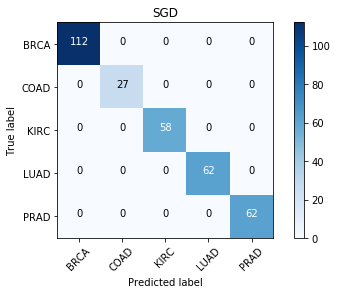

Confusion matrix, without normalization
[[112   0   0   0   0]
 [  0  27   0   0   0]
 [  0   0  58   0   0]
 [  0   0   0  62   0]
 [  0   0   0   0  62]]


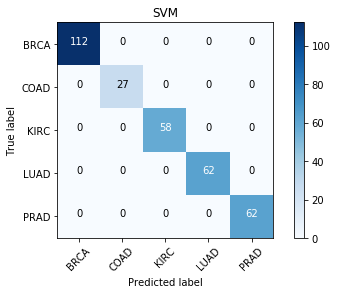

Confusion matrix, without normalization
[[112   0   0   0   0]
 [  0  27   0   0   0]
 [  0   0  58   0   0]
 [  0   0   0  62   0]
 [  0   0   0   0  62]]


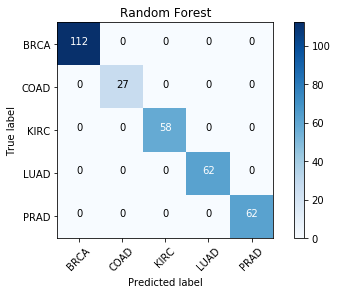

Confusion matrix, without normalization
[[112   0   0   0   0]
 [  0  24   0   3   0]
 [  0   0  58   0   0]
 [  0   0   0  62   0]
 [  0   0   0   0  62]]


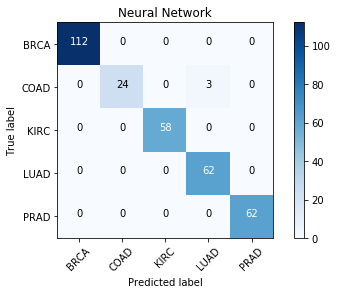

In [59]:
import itertools
from sklearn.metrics.classification import classification_report, jaccard_similarity_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier


sgd_pred = sgd_clf.predict(X_test)
svm_pred = svm_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
nn_pred = nn_clf.predict(X_test)

# measure and output accuracy
print("Jaccard similarity scores: ")
sgd_score = jaccard_similarity_score(Y_test, sgd_pred)
svm_score = jaccard_similarity_score(Y_test, svm_pred)
rf_score = jaccard_similarity_score(Y_test, rf_pred)
nn_score = jaccard_similarity_score(Y_test, nn_pred)
print("SGD Jaccard similarity score: {:5f}".format(sgd_score))
print("SVM Jaccard similarity : {:5f}".format(svm_score))
print("Random Forest Jaccard similarity score: {:5f}".format(rf_score))
print("Neural Net Jaccard similarity score: {:5f}".format(nn_score))

# plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
print("Confusion matrix plots")
# SGD
sgd_matrix = confusion_matrix(Y_test, sgd_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(sgd_matrix, classes=class_names,title='SGD')
plt.show()

# SVM
svm_matrix = confusion_matrix(Y_test, svm_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(svm_matrix, classes=class_names,title='SVM')
plt.show()

# RF
rf_matrix = confusion_matrix(Y_test, rf_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(rf_matrix, classes=class_names,title='Random Forest')
plt.show()

# NN
nn_matrix = confusion_matrix(Y_test, nn_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(nn_matrix, classes=class_names,title='Neural Network')
plt.show()

## Feature Selection using Sparse SVM and RF 
High dimensional feature space makes it hard to interpret which genes are the most critical. Imposing sparsity into the feature space can improve the inductive accuracy and interpretability.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, ensemble, linear_model
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics.classification import jaccard_similarity_score
%matplotlib inline

########################################################################################
#                    Load dataset
########################################################################################
# load the training data
print("Loading data sets...")
DATA_PATH = "data/"
X_train = pd.read_csv("%sX_train.csv" % DATA_PATH).values
Y_train = pd.read_csv("%sY_train.csv" % DATA_PATH).values
X_test = pd.read_csv("%sX_test.csv" % DATA_PATH).values
Y_test = pd.read_csv("%sY_test.csv" % DATA_PATH).values

# transform panda df into arrays
X_train = np.delete(X_train, 0, axis=1)
Y_train = np.delete(Y_train, 0, axis=1).flatten()
X_test = np.delete(X_test, 0, axis=1)
Y_test = np.delete(Y_test, 0, axis=1).flatten()

f = open("%sclass_names.txt" % DATA_PATH)
class_names = json.load(f)
f.close()

print("Dataset loaded.")


########################################################################################
#                     parameter tuning for SVM, RF and logistic regression
########################################################################################
def kfold_model_score(model, X_train, Y_train, numFolds=5):
    k_fold_shuttle = KFold(n_splits=numFolds, random_state=100).get_n_splits(X_train, Y_train)
    return np.mean(cross_val_score(model, X_train, Y_train, cv=k_fold_shuttle))


# test alpha value in increasing order
alpha_params = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 50, 100, 200, 500, 1000]


def tune_alpha(alpha_params, X_train, Y_train, X_test, Y_test):
    for alpha in alpha_params:
        model = linear_model.SGDClassifier(random_state=100, alpha=alpha, n_jobs=-1, penalty="l1", tol=1e-3)
        model = model.fit(X_train, Y_train)
        model_pred = model.predict(X_test)
        model_score = jaccard_similarity_score(Y_test, model_pred)
        print("Linear SVC score with alpha {:5f}: {:5f}".format(alpha, model_score.mean()))


tune_alpha(alpha_params, X_train, Y_train, X_test, Y_test)

# test the effect of number of tree on accuracy for random forest
rf_clf = ensemble.RandomForestClassifier(random_state=100, n_jobs=-1)
trees = [5, 10, 15, 20, 25, 50, 75, 100]


def tune_trees(trees, X_train, Y_train, X_test, Y_test):
    for tree in trees:
        model = ensemble.RandomForestClassifier(random_state=100, n_jobs=-1, n_estimators=tree)
        model = model.fit(X_train, Y_train)
        model_pred = model.predict(X_test)
        model_score = jaccard_similarity_score(Y_test, model_pred)
        print("Random Forest score with {} trees: {:5f}".format(tree, model_score.mean()))


tune_trees(trees, X_train, Y_train, X_test, Y_test)

# test  C parameters for logistic regression
C_params = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


def tune_C(C_params, X_train, Y_train, X_test, Y_test):
    for C in C_params:
        model = linear_model.LogisticRegression(random_state=100, C=C, penalty="l1")
        model = model.fit(X_train, Y_train)
        model_pred = model.predict(X_test)
        model_score = jaccard_similarity_score(Y_test, model_pred)
        print("Logistic Regression score with C={}: {:5f}".format(C, model_score.mean()))


tune_C(C_params, X_train, Y_train, X_test, Y_test)

########################################################################################
#                    Feature selection
########################################################################################
print("\nPerforming feature selection using Sparse SVM and RF \n")

# TODO
# use defealt threshold level
# 3 methods to feature selection, svm, rf, logistic regression
# 200 features, -> 20 -> 10
# draw graph to visualize different method for feature selection Y: accuracy, X: num of features

C_params = [0.00015, 0.0002, 0.00025, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.1, 1,
            10, 100, 1000, 10000, 100000, 1000000]
C_params.reverse()

n_features_svm = []
accuracy_svm = []


# perform feature selection using sparse svm
def svm_feature_selection(C_params):
    for C in C_params:
        svm_select = svm.LinearSVC(random_state=100, penalty="l1", C=C, dual=False, tol=1e-4)
        svm_select = SelectFromModel(svm_select).fit(X_train, Y_train)
        svm_features = svm_select.transform(X_train)
        print("\nWith C={}".format(C))
        print("Sparse SVM reduced number of features to {}.".format(svm_features.shape[1]))
        svm_clf_l1 = linear_model.SGDClassifier(random_state=100, penalty="l1", n_jobs=-1, alpha=0.01, tol=1e-4)
        svm_clf_l1_score = kfold_model_score(svm_clf_l1, svm_features, Y_train)
        print("SGD l1 CV score after FEATURE SELECTION: {:5f}".format(svm_clf_l1_score.mean()))
        n_features_svm.append(svm_features.shape[1])
        accuracy_svm.append(svm_clf_l1_score.mean())


svm_feature_selection(C_params)

# perform feature selection using rf, use mean as threshold
thresholds = [0, 1e-06, 2e-06, 5e-06, 1e-05, 2e-05, 5e-05, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004,
              0.005, 0.006, 0.007, 0.008, 0.009, 0.01]

n_features_rf = []
accuracy_rf = []


def rf_feature_selection(thresholds):
    for threshold in thresholds:
        rf_clf = ensemble.RandomForestClassifier(random_state=100, n_jobs=-1, n_estimators=50)
        rf_select = SelectFromModel(estimator=rf_clf, threshold=threshold)
        rf_select = rf_select.fit(X_train, Y_train)
        rf_features = rf_select.transform(X_train)
        print("\nWith threshold {}".format(threshold))
        print("RF reduced number of features to {}.".format(rf_features.shape[1]))

        rf_clf = ensemble.RandomForestClassifier(random_state=100, n_jobs=-1, n_estimators=50)
        rf_clf_score = kfold_model_score(rf_clf, rf_features, Y_train)
        print("RF CV score after FEATURE SELECTION: {:5f}".format(rf_clf_score.mean()))
        n_features_rf.append(rf_features.shape[1])
        accuracy_rf.append(rf_clf_score.mean())


rf_feature_selection(thresholds)

# perform feature selection using logistic regression
C_params = [0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.1, 1,
            10, 100, 1000, 10000, 100000, 1000000]
C_params.reverse()

n_features_logit = []
accuracy_logit = []


def logit_feature_selection(C_params):
    for C in C_params:
        logit_select = linear_model.LogisticRegression(random_state=100, penalty="l1", C=C, tol=1e-4)
        logit_select = SelectFromModel(logit_select).fit(X_train, Y_train)
        logit_features = logit_select.transform(X_train)
        print("\nWith C={}".format(C))
        print("Logistic regression reduced number of features to {}.".format(logit_features.shape[1]))
        logit_clf = linear_model.LogisticRegression(random_state=100, penalty="l1", tol=1e-4)
        logit_clf_score = kfold_model_score(logit_clf, logit_features, Y_train)
        print("Logistic regression score after FEATURE SELECTION: {:5f}".format(logit_clf_score.mean()))
        n_features_logit.append(logit_features.shape[1])
        accuracy_logit.append(logit_clf_score.mean())


logit_feature_selection(C_params)


Loading data sets...
Dataset loaded.
Linear SVC score with alpha 0.000010: 0.987578
Linear SVC score with alpha 0.000100: 0.981366
Linear SVC score with alpha 0.001000: 0.987578
Linear SVC score with alpha 0.010000: 0.993789
Linear SVC score with alpha 0.100000: 0.987578
Linear SVC score with alpha 1.000000: 0.931677
Linear SVC score with alpha 5.000000: 0.372671
Linear SVC score with alpha 50.000000: 0.173913
Linear SVC score with alpha 100.000000: 0.173913
Linear SVC score with alpha 200.000000: 0.173913
Linear SVC score with alpha 500.000000: 0.173913
Linear SVC score with alpha 1000.000000: 0.173913
Random Forest score with 5 trees: 0.962733
Random Forest score with 10 trees: 0.968944
Random Forest score with 15 trees: 0.981366
Random Forest score with 20 trees: 0.981366
Random Forest score with 25 trees: 0.987578
Random Forest score with 50 trees: 0.987578
Random Forest score with 75 trees: 0.987578
Random Forest score with 100 trees: 0.987578
Logistic Regression score with C=0.00

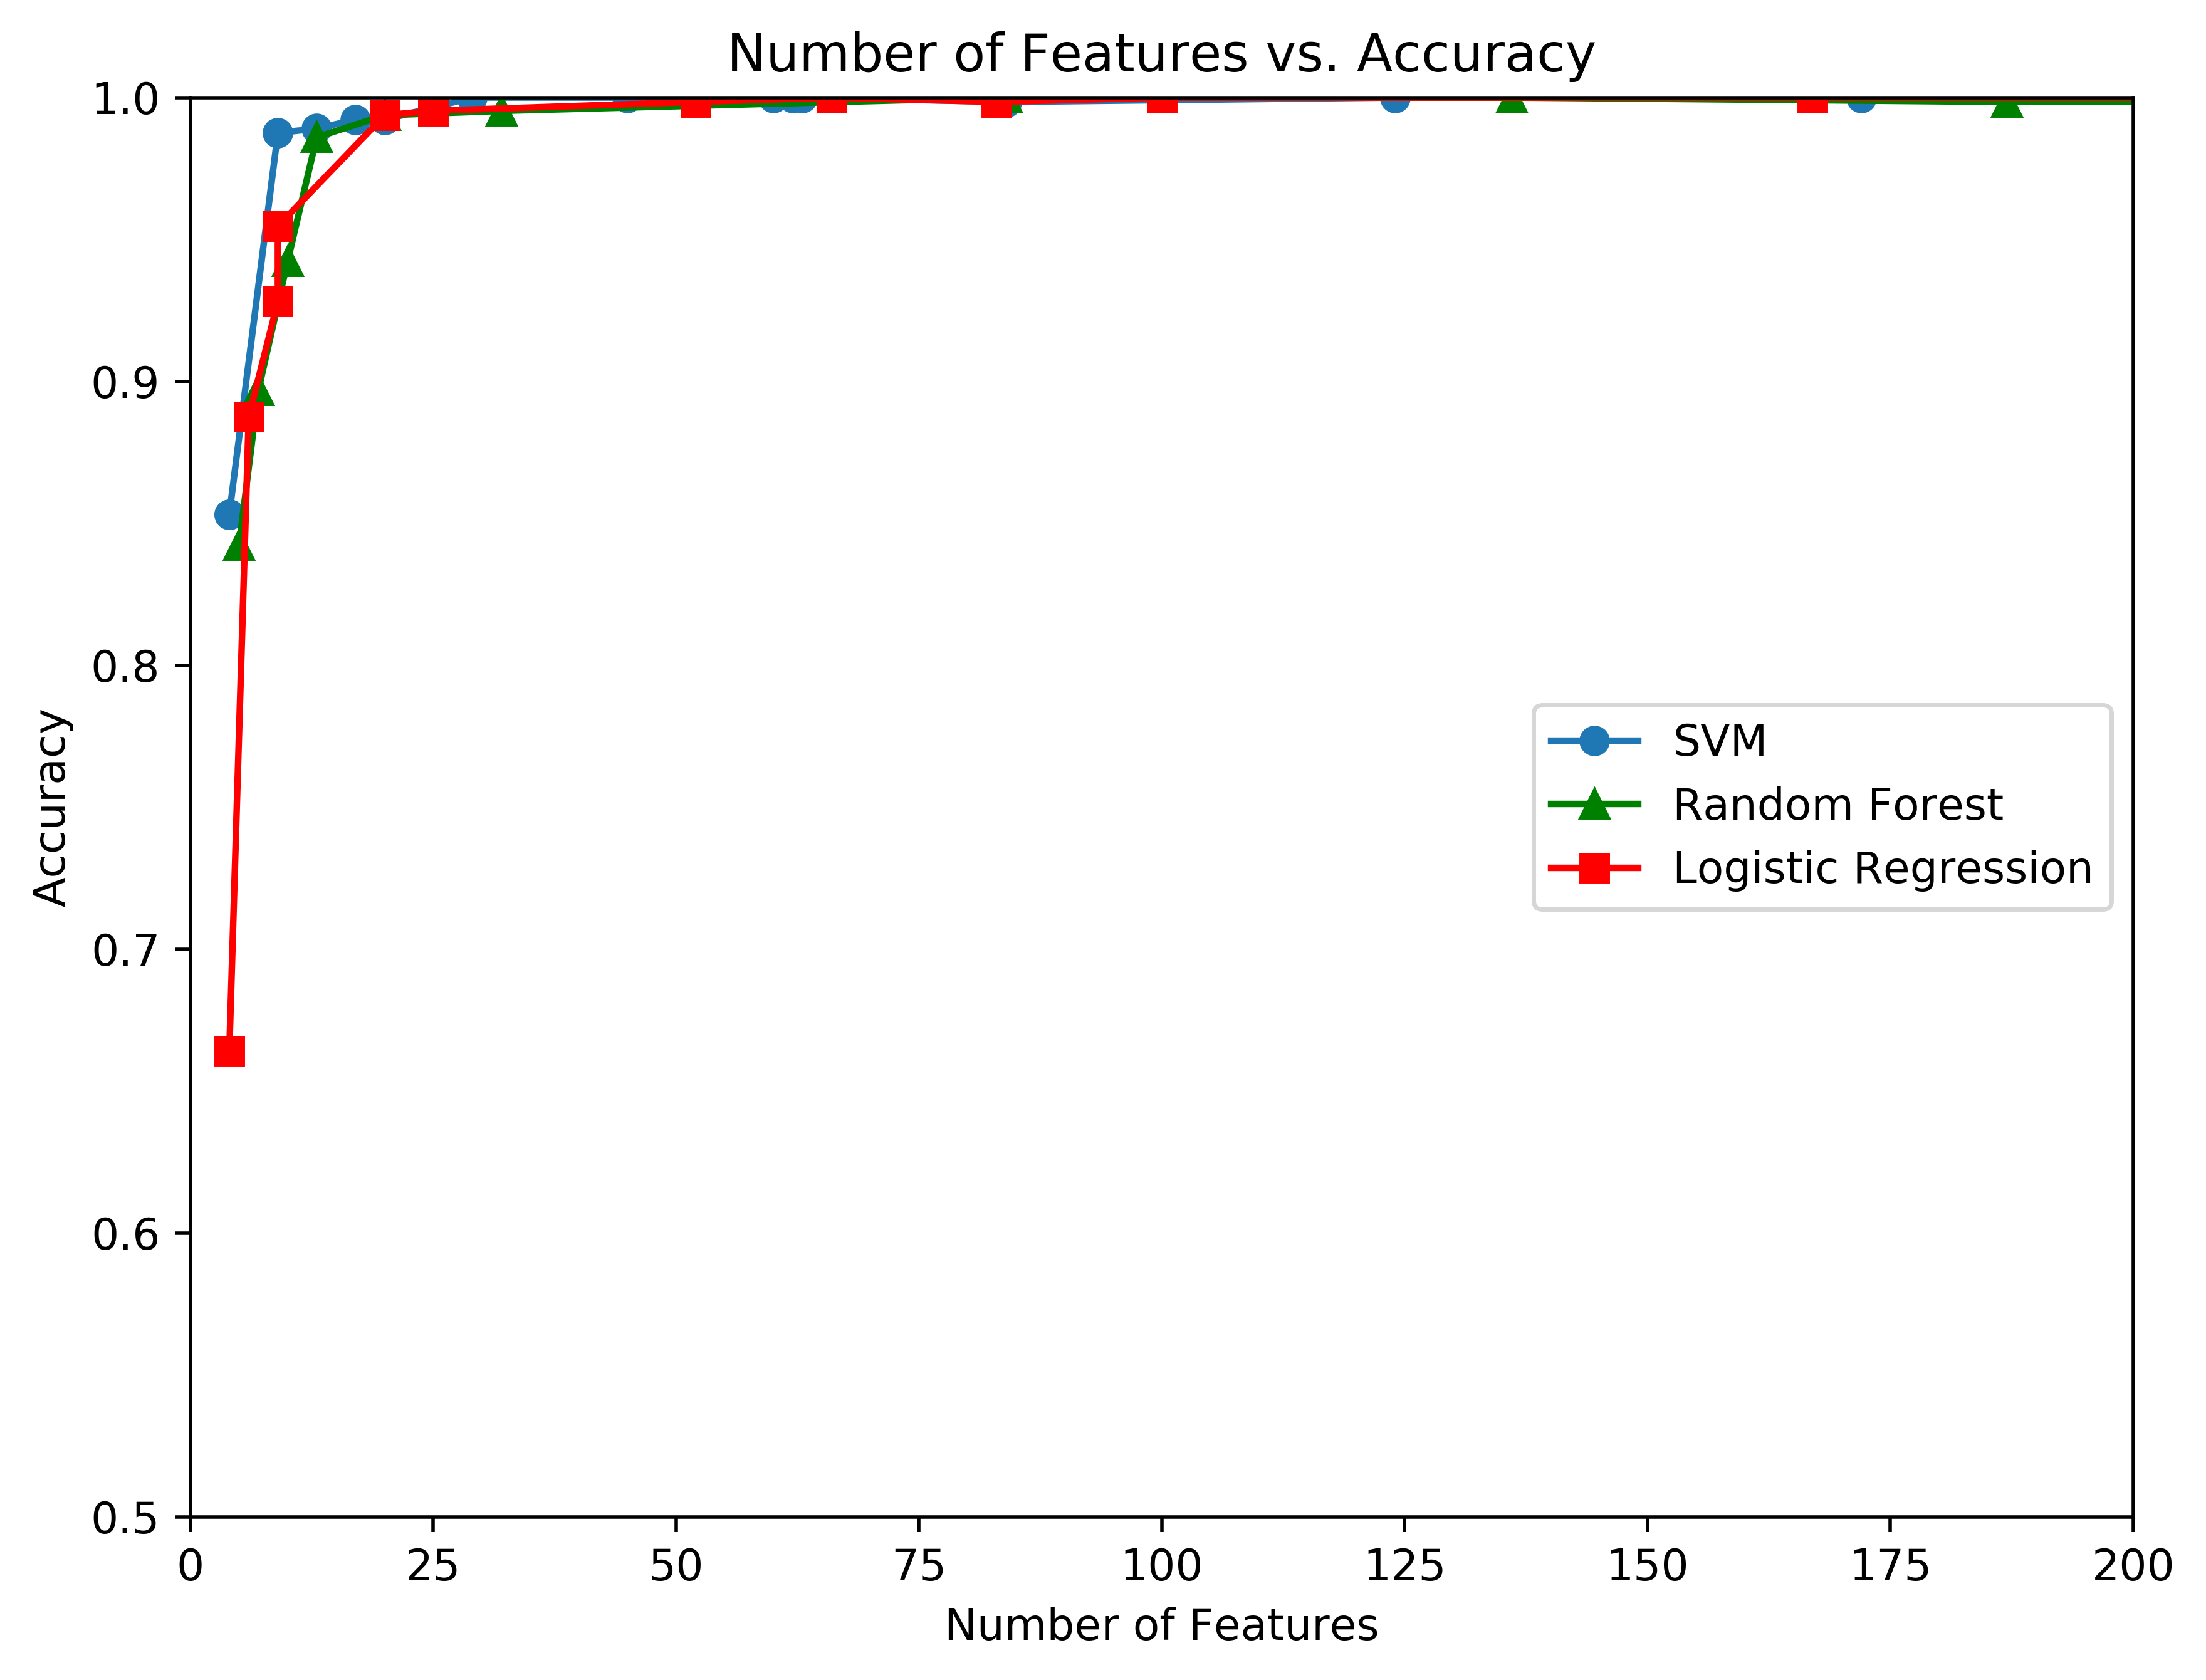

In [8]:
########################################################################################
#                    Feature Selection Performance
########################################################################################
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=500, facecolor='w', edgecolor='k')

plt.plot(n_features_svm, accuracy_svm, 'o-')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title("Number of Features vs. Accuracy")

plt.plot(n_features_rf, accuracy_rf, '^-', color='green')

plt.plot(n_features_logit, accuracy_logit, 's-', color='red')
plt.legend(['SVM', 'Random Forest', 'Logistic Regression'], loc=5)

plt.axis([0, 200, 0.5, 1])
plt.show()

## Feature Selection Results
Looking at the performance of model after feature selection of using the method of support vector machine, random forest and logistic regression. We can see that the accuracy of identify cancer types remained high until the number of features in 10 to 20 range. Among the three, SVM retained the highest accuracy after features has been reduced to 10. With 9 features, it's able to obtain 98.75% accuracy. The other two methods performance drops below 95% accuracy after number of features drops below

## Results
All four modeled performed well on the testing dataset. I am surprised by the result given such high dimensional feature spaces. SGD, SVM, and RF all achieved 100% in Jaccard similarity score. Neuron Network is slightly worse at 99% percent with 3 misclassifcations. I suspect such good results are due to parameter tuning such that the optimal parameters were found for each algorithm. Another possible cause might be the features do not have much noise, so it's hard to for algorithms to perform poorly. Considering the computational time, random forest and SGD are the most efficient algorithms in predicting the tumor outcomes given RNA microarray dataset. For future work, I would love to test the algorithms on more RNA microarray dataset or similar high dimensional problems. 